In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


## **Loading and Cleaning the Data**

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx'
df = pd.read_excel(url, sheet_name='Year 2010-2011')

print(df.info())

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df['Invoice'] = df['Invoice'].astype(str)
df = df[~df['Invoice'].str.startswith('C')]
df['TotalPrice'] = df['Quantity'] * df['Price']

<ipython-input-3-d6425e00dd8c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalPrice'] = df['Quantity'] * df['Price']


In [4]:
print(df.isnull().sum())
df = df.dropna(subset=['Customer ID'])
print(df.isnull().sum())

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    134697
Country             0
TotalPrice          0
dtype: int64
Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
TotalPrice     0
dtype: int64


## **RFM Analysis**

In [5]:
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,   # Recency: days since last purchase
    'Invoice': 'nunique',                                       # Frequency: number of unique invoices
    'TotalPrice': 'sum'                                         # Monetary: total amount spent
}).rename(columns={'InvoiceDate': 'Recency', 'Invoice': 'Frequency', 'TotalPrice': 'Monetary'})

print(rfm.head())

             Recency  Frequency  Monetary
Customer ID                              
12346.0          326          1  77183.60
12347.0            2          7   4310.00
12348.0           75          4   1797.24
12349.0           19          1   1757.55
12350.0          310          1    334.40


## **Data Normalizing and Scaling**

In [6]:
rfm['Recency_log'] = np.log1p(rfm['Recency'])
rfm['Frequency_log'] = np.log1p(rfm['Frequency'])
rfm['Monetary_log'] = np.log1p(rfm['Monetary'])

features = rfm[['Recency_log', 'Frequency_log', 'Monetary_log']]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

## **Determining the Number of Clusters**

#### Elbow Method

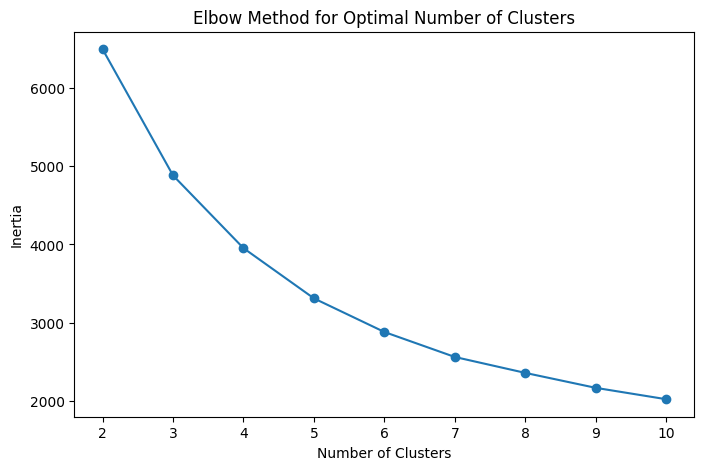

In [7]:
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()


#### Silhouette Score

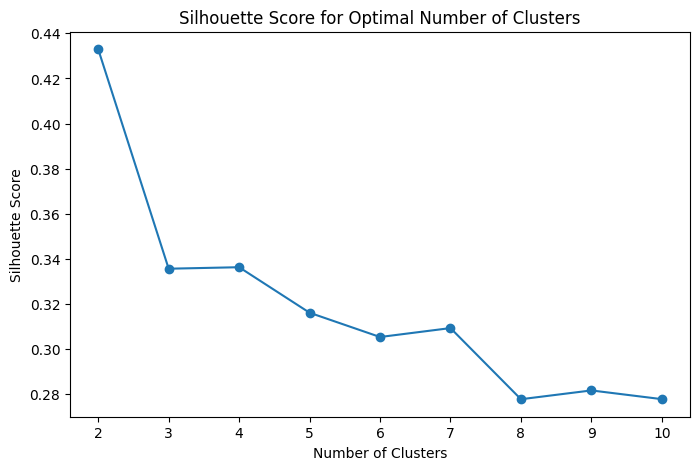

In [8]:
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    score = silhouette_score(features_scaled, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.show()

## **K-Means Clustering**

In [9]:
n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(features_scaled)

print(rfm['Cluster'].value_counts())

cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

print(cluster_summary)

Cluster
3    1594
2    1183
0     839
1     723
Name: count, dtype: int64
   Cluster     Recency  Frequency     Monetary
0        0   18.725864   2.090584   538.252741
1        1   12.112033  13.634855  8015.424412
2        2   70.697380   4.076923  1791.090873
3        3  184.023839   1.318068   342.421268


## **Results and Visualizations**

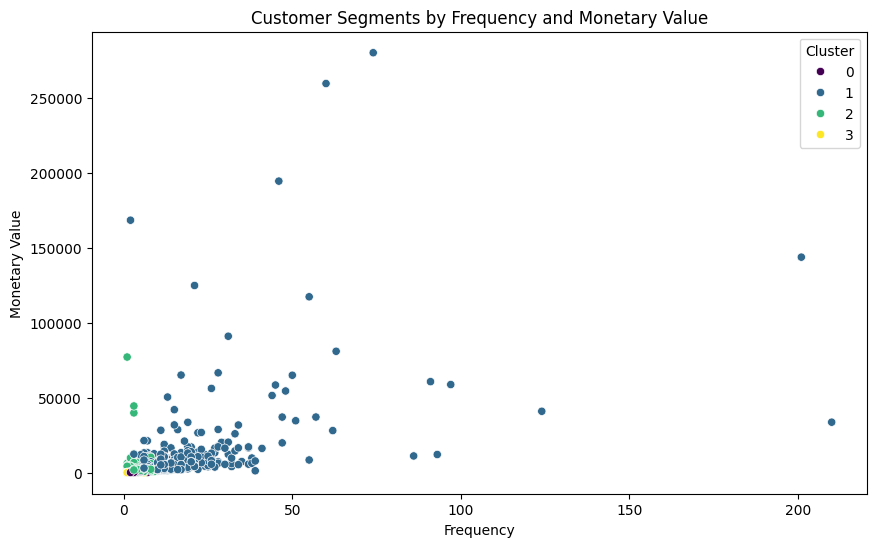

<ipython-input-10-f46db0da7abd>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Cluster', data=rfm, palette='viridis')


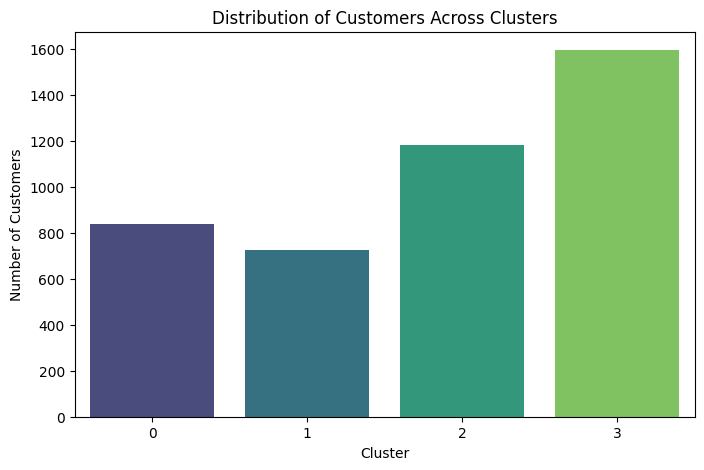

In [10]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Frequency', y='Monetary', hue='Cluster', data=rfm, palette='viridis')
plt.title('Customer Segments by Frequency and Monetary Value')
plt.xlabel('Frequency')
plt.ylabel('Monetary Value')
plt.show()

plt.figure(figsize=(8, 5))
sns.countplot(x='Cluster', data=rfm, palette='viridis')
plt.title('Distribution of Customers Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()

<ipython-input-11-e4fccd6c9946>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Recency', data=rfm, palette='viridis')
<ipython-input-11-e4fccd6c9946>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Frequency', data=rfm, palette='viridis')
<ipython-input-11-e4fccd6c9946>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Monetary', data=rfm, palette='viridis')


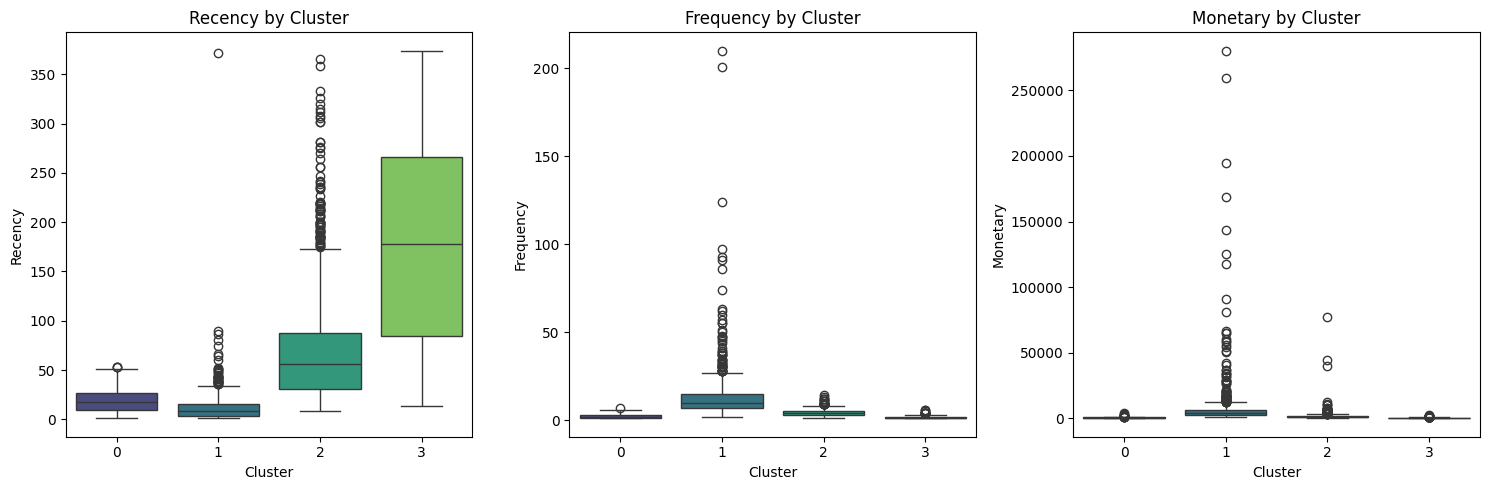

In [11]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='Cluster', y='Recency', data=rfm, palette='viridis')
plt.title('Recency by Cluster')

plt.subplot(1, 3, 2)
sns.boxplot(x='Cluster', y='Frequency', data=rfm, palette='viridis')
plt.title('Frequency by Cluster')

plt.subplot(1, 3, 3)
sns.boxplot(x='Cluster', y='Monetary', data=rfm, palette='viridis')
plt.title('Monetary by Cluster')

plt.tight_layout()
plt.show()

#### Cluster Characteristics:
 - **Cluster 0** (839 customers):
   - Low Recency (18.7 days), Low Frequency (2.1 purchases), Moderate Monetary Value (£538.25)
   - These are **recent but low-engagement customers**. They have made purchases recently but have low frequency and spending.


 - **Cluster 1** (723 customers):
   - Very Low Recency (12.1 days), High Frequency (13.6 purchases), High Monetary Value (£8015.42)
   - These are **high-value, loyal customers**. They purchase frequently and spend the most.

 - **Cluster 2** (1183 customers):
   - High Recency (70.7 days), Moderate Frequency (4.1 purchases), Moderate Monetary Value (£1791.09)
   - These are **at-risk customers**. They haven’t purchased recently but have moderate engagement.

 - **Cluster 3** (1594 customers):
   - Very High Recency (184 days), Low Frequency (1.3 purchases), Low Monetary Value (£342.42)
   - These are **inactive customers**. They haven’t purchased in a long time and have low engagement.

#### Actionable Insights
 - **Cluster 0**
   - These customers have potential but need incentives to increase their frequency and spending.
   - Marketing Strategy: Encourage repeat purchases with targeted promotions or loyalty programs.

 - **Cluster 1**
   - These customers are the most valuable. Retaining them should be a top priority.
   - Marketing Strategy: Reward loyalty with exclusive offers or VIP programs to retain them.

 - **Cluster 2**
   - These customers are at risk of churn. Targeted campaigns can bring them back.
   - Marketing Strategy: Re-engage with personalized offers or reminders to prevent churn.

 - **Cluster 3**
   - While they are currently inactive, win-back campaigns could rekindle their interest.
   - Marketing Strategy: Win-back campaigns with discounts or reactivation offers.